https://mp.weixin.qq.com/s/7HRsULbkyD02rPIWUud7dQ

### 基金绩效衡量概况

一般地，基金的绩效衡量从 3 个角度来考虑——盈利能力，抗风险能力和风险调整后的收益指标。

- 其中盈利能力常用的有阶段收益率，詹森 alpha 等。
- 抗风险能力常用的有波动率(标准差)，亏损比例(阶段中净值亏损出现的频率)，平均亏损(出现亏损时亏损的均值)和杠杆率等。
- 风险调整后指标常用的有 Sharpe 比率，Sotino 比率，信息比，上行捕获率，下行捕获率等。


In [1]:
import numpy as np
import pandas as pd
import talib as ta
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,5

## 获取基金列表和基金净值
[基金列表](https://www.joinquant.com/help/api/help#fund:%E5%9F%BA%E9%87%91%E5%88%97%E8%A1%A8)

In [3]:
start_date, end_date = "2021-01-01", "2021-12-31"
code = '161005.XSHE'

获取基本信息

In [4]:
info = get_security_info(code)
code, info.display_name,info.type, info.start_date, info.end_date

('161005.XSHE',
 '富国天惠LOF',
 'lof',
 datetime.date(2006, 2, 16),
 datetime.date(2200, 1, 1))

[获取基金净值](https://www.joinquant.com/help/api/help#fund:%E5%9F%BA%E9%87%91%E7%B4%AF%E8%AE%A1%E5%8D%95%E4%BD%8D%E5%87%80%E5%80%BC)

- acc_net_value: 基金累计净值
- unit_net_value: 基金单位净值

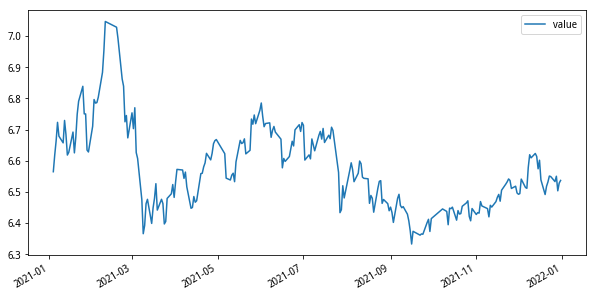

In [5]:
fund = get_extras('acc_net_value', [code], start_date=start_date, end_date=end_date, df=True,count=None)
fund.rename(inplace=True, columns={code: 'value'})
fund.plot()

用今日净值减去昨日净值算出每日的收益率

In [6]:
fund['pre_value'] = fund['value'].shift(1).fillna(method='bfill')
fund['return'] = np.log(np.array(fund['value'])/np.array(fund['pre_value'])) #基金收益率序列
fund.head(10)

,value,pre_value,return
2021-01-04,6.5647,6.5647,0.000000
2021-01-05,6.6181,6.5647,0.008102
2021-01-06,6.6634,6.6181,0.006822
2021-01-07,6.7232,6.6634,0.008934
2021-01-08,6.6788,6.7232,-0.006626
2021-01-11,6.6573,6.6788,-0.003224
2021-01-12,6.7293,6.6573,0.010757
2021-01-13,6.6842,6.7293,-0.006725
2021-01-14,6.6182,6.6842,-0.009923
2021-01-15,6.6270,6.6182,0.001329


根据每日收益计算波动率

In [7]:
vol = np.std(fund['return'])
vol

0.0067263211122917475

计算区间收益

In [8]:
return_period = sum(fund['return'])
return_period

-0.004274358867039373

计算亏损比例和平均亏损

In [9]:
loss_rate = len(fund[fund['return']<0]) / len(fund['return']) #亏损比例
loss_avg = fund['return'][fund['return']<0].mean()
loss_rate, loss_avg

(0.4691358024691358, -0.005480923192467324)

## 获取比较基准沪深300指数的数据

[上海市场指数列表](
https://www.joinquant.com/help/api/help#index:%E4%B8%8A%E6%B5%B7%E5%B8%82%E5%9C%BA%E6%8C%87%E6%95%B0%E5%88%97%E8%A1%A8)

获取指数每日收盘数据

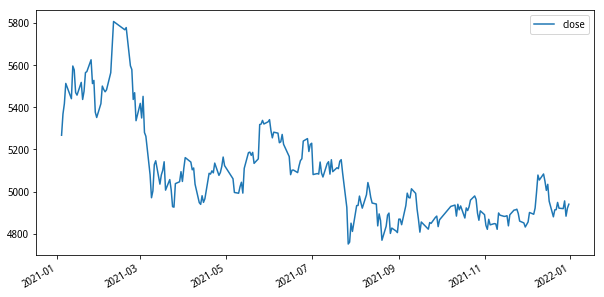

In [10]:
hs300 = get_price('000300.XSHG', 
                  start_date=start_date, # 开始日期
                  end_date=end_date,     # 结束日期
                  frequency='daily',     # 日线数据
                  fields=['close'],      # 获取字段
                  skip_paused=False,     # 是否跳过不交易日期，如不跳过，停牌时会使用停牌前的数据填充
                  fq='pre'               # 前复权 
         )
hs300.plot()

计算每日收益率

In [11]:
hs300['pre_close'] = hs300['close'].shift(1).fillna(method='bfill')
hs300['return'] = np.log(np.array(hs300['close'])/np.array(hs300['pre_close']))
hs300.head(10)

,close,pre_close,return
2021-01-04,5267.72,5267.72,0.000000
2021-01-05,5368.50,5267.72,0.018951
2021-01-06,5417.67,5368.50,0.009117
2021-01-07,5513.66,5417.67,0.017563
2021-01-08,5495.43,5513.66,-0.003312
2021-01-11,5441.16,5495.43,-0.009925
2021-01-12,5596.35,5441.16,0.028122
2021-01-13,5577.97,5596.35,-0.003290
2021-01-14,5470.46,5577.97,-0.019462
2021-01-15,5458.08,5470.46,-0.002266



## 获取无风险收益率数据
[银行间拆借利率表（日级）](https://www.joinquant.com/help/api/help#macroData:%E9%93%B6%E8%A1%8C%E9%97%B4%E6%8B%86%E5%80%9F%E5%88%A9%E7%8E%87%E8%A1%A8%EF%BC%88%E6%97%A5%E7%BA%A7%EF%BC%89%EF%BC%89)

无风险利率用 3 个月的 SHIBOR 来近似

In [12]:
from jqdata import macro
q = query(macro.MAC_LEND_RATE).filter(
    macro.MAC_LEND_RATE.market_id==5,
    macro.MAC_LEND_RATE.day>=start_date,
    macro.MAC_LEND_RATE.day<=end_date,
    macro.MAC_LEND_RATE.term_id==3,
)
rf_df = macro.run_query(q)
rf_df = rf_df.set_index('day')
rf_df.head()

,id,currency_id,market_id,term_id,interest_rate,currency_name
day,,,,,,
2021-01-04,1006863,1,5,3,2.746,人民币
2021-01-05,1006879,1,5,3,2.734,人民币
2021-01-06,1006926,1,5,3,2.707,人民币
2021-01-07,1006972,1,5,3,2.677,人民币
2021-01-08,1007019,1,5,3,2.645,人民币


In [13]:
rf = fund.join(rf_df)['interest_rate']/100

## 计算阿尔法和贝塔收益

In [14]:
x, y = hs300['return'].values - rf.values, fund['return'].values - rf.values
x = x.reshape(len(x), 1)
C = np.ones((len(x), 1))
X = np.hstack((C,x))
res = (sm.OLS(y,X)).fit()
alpha, beta = res.params[0],res .params[1]
alpha, beta

(-0.011268586154025656, 0.5473820574535458)

## 计算夏普比率，所提诺比率和信息比率

In [15]:
return_period,rf.mean(),vol

(-0.004274358867039373, 0.025176901234567926, 0.0067263211122917475)

In [16]:
sharpe_ratio = (return_period  - rf.mean())/vol
sotino_ratio = (return_period - rf.mean())/ beta
IR = res.resid.mean()/res.resid.std()
sharpe_ratio, sotino_ratio, IR

(-4.378509382757206, -0.05380384632740124, -3.672356403936595e-15)

## 打印基金评价概要

In [17]:
from IPython.display import HTML, display
import tabulate
table = [
            ['基金代码', code, '基金名称',info.display_name],
            ['统计开始日期', start_date, '统计结束日期', end_date],
            ['阶段收益率', return_period, '波动率', vol], 
            ['詹森系数(alpha)', alpha, 'beta', beta], 
            ['亏损比例', loss_rate, '平均亏损', loss_avg],            
            ['Sharpe比率', sharpe_ratio, 'Sotino比率', sotino_ratio],
            ['信息比', IR,'','']
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

基金代码,161005.XSHE,基金名称,富国天惠LOF
统计开始日期,2021-01-01,统计结束日期,2021-12-31
阶段收益率,-0.004274358867039373,波动率,0.0067263211122917475
詹森系数(alpha),-0.011268586154025656,beta,0.5473820574535458
亏损比例,0.4691358024691358,平均亏损,-0.005480923192467324
Sharpe比率,-4.378509382757206,Sotino比率,-0.05380384632740124
信息比,-3.672356403936595e-15,,


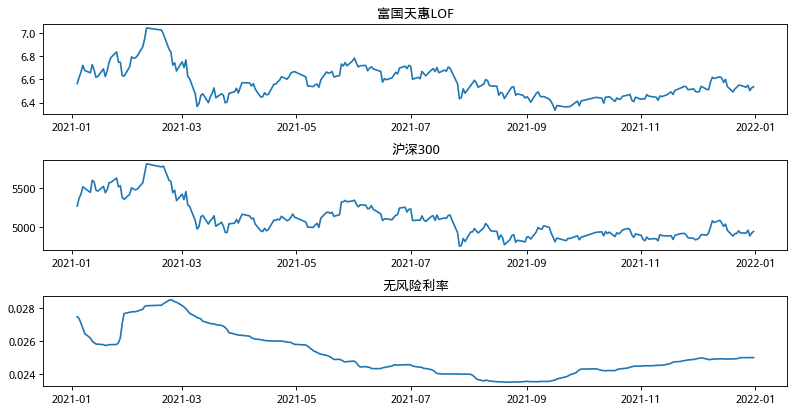

In [18]:
import  matplotlib.pyplot as plt
plt.figure(figsize=(12,6), dpi=80)
plt.figure(1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)
ax1 = plt.subplot(311, title=info.display_name)
plt.plot(fund['value'])
ax2 = plt.subplot(312, title='沪深300')
plt.plot(hs300['close'])
ax3 = plt.subplot(313,title='无风险利率')
plt.plot(rf)